In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("D:\\DRUG\\Drug_CNN\\data_for_gnn.tsv",sep='\t')

In [3]:
df.head()

,smiles,interact_with_adenosine
0,BrC1=C(NC2=NCCN2)C=CC2=NC=CN=C12,0
1,C#CC1=CC=CC(NC2=NC=NC3=C2C=C2OCCOCCOCCOC2=C3)=C1,0
2,C#CCN[C@@H]1CCC2=C1C=CC=C2,0
3,CC(C)(C)C1=CC=C(C=C1)C(=O)CCCN1CCC(CC1)OC(C1=C...,1
4,C(C1=NCCN1)C1=CC=CC2=CC=CC=C12,0


In [4]:
atoms={}
i=0
maxm=0
for x in df['smiles']:
    maxm=max(maxm,len(x))
    for j in x:
        if j not in atoms:
            atoms[j]=i
            i+=1


In [5]:
maxm

3821

In [6]:
len(atoms)

36

In [7]:
# from collections import defaultdict

# import numpy as np

# from rdkit import Chem

# import torch

In [8]:
input_data=[]
for x,y in zip(df['smiles'],df['interact_with_adenosine']):
    tsr=[[0]*maxm for i in range(len(atoms))]
    k=0
    for j in x:
        tsr[atoms[j]][k]=1
        k+=1
    input_data.append([tsr,y])


In [9]:
import numpy as np

In [10]:
def split_dataset(dataset, ratio):
    """Shuffle and split a dataset."""
    np.random.seed(1234)  # fix the seed for shuffle.
    np.random.shuffle(dataset)
    n = int(ratio * len(dataset))
    return dataset[:n], dataset[n:]

In [11]:
dataset_train, dataset_test=split_dataset(input_data,0.8)

In [12]:
train_gen=np.array([np.array(x[0]).reshape(36,3821,1) for x in dataset_train])
train_lab=np.array([x[1] for x in dataset_train])
test_gen=np.array([np.array(x[0]).reshape(36,3821,1) for x in dataset_test])
test_lab=np.array([x[1] for x in dataset_test])

In [13]:
from tensorflow.keras.utils import to_categorical
train_lab=to_categorical(train_lab,2)
test_lab=to_categorical(test_lab,2)

In [14]:
train_gen[0].shape

(36, 3821, 1)

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es= EarlyStopping(monitor="accuracy",min_delta=0.04,patience=6,verbose=1,mode='auto')
mc=ModelCheckpoint(monitor="accuracy",filepath="D:\Phase II Project Work\DRUG\Drug_CNN\DTI\DTI.h5",verbose=1,save_best_only=True,mode='auto')
cd=[es,mc]

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,GlobalAvgPool2D,GaussianNoise,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3072)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [18]:
train_gen.shape

(1594, 36, 3821, 1)

In [19]:
import tensorflow as tf
# base_model = tf.keras.applications.EfficientNetB2(weights='imagenet',input_shape=(256,256,1), include_top=False)
# base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', input_shape=(224,224,3), include_top=False)
# with tf.device('/GPU:0'):
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu',padding='Same', input_shape=(36,3821,1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 3821, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 1910, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 1908, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 954, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 952, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 365568)            0

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall'])

In [21]:

              
hs=model.fit(
    train_gen,
    train_lab,
    batch_size=16,
    epochs=8,
    verbose=1,  
    validation_data=(test_gen,test_lab),
    callbacks=cd
    )


Epoch 1/8
100/100 [==============================] - ETA: 0s - loss: 0.6168 - accuracy: 0.6662 - precision: 0.6662 - recall: 0.6662
Epoch 1: accuracy improved from -inf to 0.66625, saving model to D:\Phase II Project Work\DRUG\Drug_CNN\DTI\DTI.h5
100/100 [==============================] - 38s 268ms/step - loss: 0.6168 - accuracy: 0.6662 - precision: 0.6662 - recall: 0.6662 - val_loss: 0.5511 - val_accuracy: 0.7143 - val_precision: 0.7143 - val_recall: 0.7143
Epoch 2/8
100/100 [==============================] - ETA: 0s - loss: 0.4171 - accuracy: 0.7917 - precision: 0.7917 - recall: 0.7917
Epoch 2: accuracy improved from 0.66625 to 0.79172, saving model to D:\Phase II Project Work\DRUG\Drug_CNN\DTI\DTI.h5
100/100 [==============================] - 26s 257ms/step - loss: 0.4171 - accuracy: 0.7917 - precision: 0.7917 - recall: 0.7917 - val_loss: 0.2737 - val_accuracy: 0.8947 - val_precision: 0.8947 - val_recall: 0.8947
Epoch 3/8
100/100 [==============================] - ETA: 0s - loss: 0.

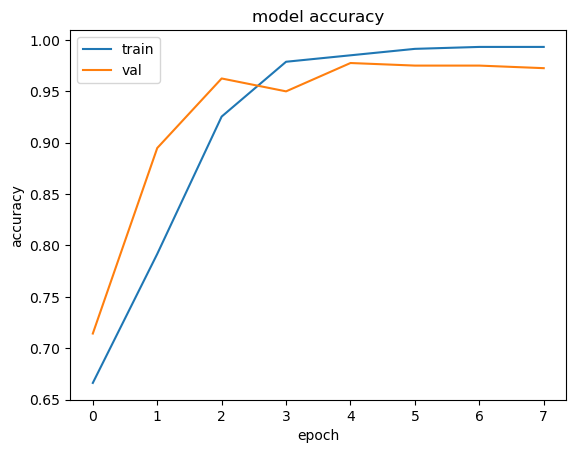

In [22]:
from matplotlib import pyplot as plt
plt.plot(hs.history['accuracy'])
plt.plot(hs.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
import numpy as np
def predict_output(x,model):
    tsr=[[0]*maxm for i in range(36)]
    k=0
    for j in x:
        tsr[atoms[j]][k]=1
        k+=1
    tsr=np.array(tsr).reshape(36,3821,1)
    res=int(np.argmax(model.predict(np.array([tsr,]))))
    print(res)
    if(res==1):
        print("the drugs will interact with adenosine ")
    else:
        print("the drugs will not interact with adenosine" )

In [24]:
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

def draw_3d(mols):
    
    mol = Chem.MolFromSmiles(mols)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())


    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=400, height=400)
    viewer.addModel(mblock, 'sdf')
    viewer.setStyle({'stick':{}})
    viewer.setBackgroundColor('0xeeeeee')
    viewer.zoomTo()
    viewer.show()

def draw_2d(mols):
     return Draw.MolToImage(Chem.MolFromSmiles(mols),size=(400,400))


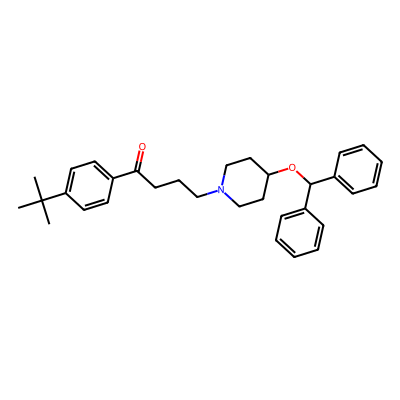

In [25]:
x="CC(C)(C)C1=CC=C(C=C1)C(=O)CCCN1CCC(CC1)OC(C1=CC=CC=C1)C1=CC=CC=C1"
draw_2d(x)

In [26]:
draw_3d(x)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [27]:
from tensorflow import keras
model = keras.models.load_model('D:\\Phase II Project Work\\DRUG\\Drug_CNN\\DTI\\DTI.h5')

In [28]:
predict_output(x,model)

1/1 [==============================] - 0s 463ms/step
1
the drugs will interact with adenosine 


In [29]:
y="CC(C)(CO)C1=CC2=C(C=C(F)C(NC(=O)C3(CC3)C3=CC=C4OC(F)(F)OC4=C3)=C2)N1C[C@@H](O)CO"
predict_output(y,model)

1/1 [==============================] - 0s 34ms/step
0
the drugs will not interact with adenosine
